## Imports

In [14]:
import numpy as np
from collections import namedtuple, deque
from tqdm import tqdm
import gym
from datetime import datetime
import pandas as pd  
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import itertools
import matplotlib.pyplot as plt
import gym


### Parameters of the environment for all the models

In [ ]:
# Environment parameters
gravity= -9.8
enable_wind = False
wind_power = 10.0
turbulence_power = 2.0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define Network for Policy gradient

### Policy network

In [ ]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden1 = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)

        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

# Fucntion to compute discounted returns
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

### Initialize the environment

In [ ]:
env = gym.make(
    "LunarLander-v2",
    gravity = gravity,
    enable_wind = enable_wind,
    wind_power = wind_power,
    turbulence_power = turbulence_power,
)

### Train the model

In [ ]:
num_episodes = 5000
rollout_limit = 1000 # max rollout length
discount_factor = 0.98 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.01 # you know this by now
val_freq = 100 # validation frequency

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate).to(device)

# train policy network

# Create a list of rewards and losses
training_rewards, losses = [], []

print('Start training')
# Train on num_episodes game play sessions
for i in tqdm(range(num_episodes)):

    # Store a list of rollout values
    rollout = []

    # Reset the environment
    s, _ = env.reset()

    # Evaluate a policy by running it in an environment and collecting training data
    for j in range(rollout_limit):
        # generate rollout by iteratively evaluating the current policy on the environment
        
        # Do not learn from this
        with torch.no_grad():

            # Create a probability list of actions with the current state as input
            a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float().to(device))

            # Sample an action from the action probabilities
            a = torch.multinomial(a_prob.cpu(), num_samples=1).squeeze().numpy()

        # Take the action and observe the next state and reward
        s1, r, done, _, _ = env.step(a)

        # Store the state, action, reward, and action probability in rollout
        rollout.append((s, a, r))

        # Update the state
        s = s1

        # If the episode is done, break out of the loop
        if done: break

    # Using the rollout collected from evaluation above, compute the discounted rewards of the policy's performance
    # At first iteration this will be the reward calculation for taking random actions
    rollout = np.array(rollout)
    states = np.vstack(rollout[:,0])
    actions = np.vstack(rollout[:,1])
    rewards = np.array(rollout[:,2], dtype=float)
    returns = compute_returns(rewards, discount_factor)


    # Zero gradients so losses do not accumulate between episodes. Meaning this training step is not dependent on the previous training step
    # As I understand it, this is because we want to let the network try to learn something new each time
    policy.optimizer.zero_grad()

    # Create a probability list of actions using the list of states given actions
    a_probs = policy(torch.from_numpy(states).float().to(device)).gather(1, torch.from_numpy(actions).to(device)).view(-1)

    # Calculate the loss using the policy's loss function
    # Notice that this where the returns or rewards are used
    # The loss is the negative of the mean of the log of the action probabilities multiplied by the returns
    # This is what instructs our model to learn to do actions that lead to higher returns
    # It does not have any other use than a metric to tell the model what to learn
    loss = policy.loss(a_probs, torch.from_numpy(returns).float().to(device))

    # Figure out where we can decrease the loss the most
    loss.backward()

    # Take a step in the direction of the loss decrease using the optimizer
    policy.optimizer.step()

    # Keep a running list of the rewards and losses of each training iteration
    training_rewards.append(sum(rewards))
    losses.append(loss.item())

    # Print the average reward of the last 10 episodes
    if (i+1) % val_freq == 0:

        # Evaluate performance of the policy
        validation_rewards = []

        # For 10 game play session
        for r in range(10):
            
            # Reset the environment
            s, _ = env.reset()

            # Reset the reward
            reward = 0

            # For rollout_limit frames
            for _ in range(rollout_limit):
                    
                # Do not learn from this
                with torch.no_grad():

                    # Create a probability list of actions with the current state as input
                    a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float().to(device))

                    # Sample an action from the action probabilities
                    a = a_prob.argmax().item()

                # Take the action and observe the next state and reward
                s, r, done, _, _ = env.step(a)

                # Add the reward to the total reward to get a mean over 10 game play sessions
                reward += r
                if done: 
                    break

            # Add the total reward to the list of validation rewards
            validation_rewards.append(reward)
print('done')

model_path=f'model/PolicyGradient_{i}_{datetime.now().strftime("%Y%m%d%H%M%S")}'
torch.save(policy.state_dict(), model_path + '.pth')

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

gradient_name='plots/result_Policy_Gradient_'+str(datetime.now().strftime("%Y%m%d%H%M%S"))
df=pd.DataFrame({'training_rewards':training_rewards,'avg_training':moving_average(training_rewards),
                 'loss':losses, 'avg_loss':moving_average(losses)})
df.to_csv(gradient_name+'.csv')

print(f'Model name: {model_path}.pth')
print(f'Logs in: {gradient_name}.csv')

## Define the network for DQN and DDQN

### Some hyperparameters

In [15]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

### Q Network class

In [16]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer class

In [17]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer (chosen as multiple of num agents)
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.next_states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=np.float)

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        
        self.actions[self.ptr] = torch.from_numpy(np.asarray(action)).to(device)
        self.rewards[self.ptr] = torch.from_numpy(np.asarray(reward)).to(device)
        self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        
        idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

### DDQNAgent Class

In [18]:
class DDQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed=42, ddqn=True):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.ddqn = ddqn
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample()
                e = self.learn(experiences)
                self.memory.update_error(e, idx)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.ddqn:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else: # Normal DQN
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        if self.ddqn:
            old_val = self.qnetwork_local(states).gather(-1, actions)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else: # Normal DQN
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)   
        
        loss = F.mse_loss(old_val, target)
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        return old_val - target


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


## Train the network

In [20]:
env = gym.make(
    "LunarLander-v2",
    gravity = gravity,
    enable_wind = enable_wind,
    wind_power = wind_power,
    turbulence_power = turbulence_power,
)


In [21]:
# Models to train
ls=[[False,'DQN'],[True,'DDQN']]

# Number of episodes and max length of an episode (in steps)
n_episodes=5000
max_t=1000

# Define epsilon behaviour
eps_start=1.0
eps_end=0.01
eps_decay=0.995

for j in ls:
    rewards = []
    aver_reward = []
    aver = deque(maxlen=100)
    scores = []
    state_size = env.observation_space.shape[0]
    action_size=env.action_space.n
    agent = DDQNAgent(state_size, action_size, 1, ddqn=j[0])
    eps = eps_start     # initialize epsilon
    for i_episode in tqdm(range(1, n_episodes+1)):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        # Add score to the queue to consider the last 100 for the average
        aver.append(score)     
        scores.append(score)
        aver_reward.append(np.mean(aver))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
    # Save model
    model_path=f'model/{j[1]}_{n_episodes}_{datetime.now().strftime("%Y%m%d%H%M%S")}'
    torch.save(agent.qnetwork_local.state_dict(), model_path+'.pth')
    print(f'Model name: {model_path}.pth')
    
    # Define path for the logs to be save to
    if not j[0]:
        file_dqn='plots/result_DQN'+str(datetime.now().strftime("%Y%m%d%H%M%S"))
        file_name = file_dqn
    else:
        file_ddqn='plots/result_DDQN'+str(datetime.now().strftime("%Y%m%d%H%M%S"))
        file_name = file_ddqn

    df=pd.DataFrame({'score':scores,'avg_score':aver_reward})
    df.to_csv(file_name+'.csv')
    print(f'Logs in: {file_name}.csv')

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Model name: model/DQN_200_20221220190219.pth
Logs in: plots/result_DQN20221220190219.csv


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]

Model name: model/DDQN_200_20221220190524.pth
Logs in: plots/result_DDQN20221220190524.csv


## Policy

In [22]:
'''df = pd.read_csv(file_name + '.csv')
df.head()
df['training_rewards']
df['avg_training']

plt.figure(figsize=(12,3))

plt.plot(range(1, len(df['training_rewards'])+1), df['training_rewards'], label='training reward')
plt.plot(df['avg_training'], label='average training reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

# save the figure
plt.savefig('Policy_Gradient_training_rewards.png', bbox_inches='tight')
'''

"df = pd.read_csv(file_name + '.csv')\ndf.head()\ndf['training_rewards']\ndf['avg_training']\n\nplt.figure(figsize=(12,3))\n\nplt.plot(range(1, len(df['training_rewards'])+1), df['training_rewards'], label='training reward')\nplt.plot(df['avg_training'], label='average training reward')\nplt.xlabel('episode'); plt.ylabel('reward')\nplt.xlim((0, len(training_rewards)))\nplt.legend(loc=4); plt.grid()\n\n# save the figure\nplt.savefig('Policy_Gradient_training_rewards.png', bbox_inches='tight')\n"

## Generate figures

### Policy gradient

In [ ]:
df = pd.read_csv(gradient_name + '.csv')

plt.figure(figsize=(12,3))

plt.plot(range(1, len(df['training_rewards'])+1), df['training_rewards'], label='training reward')
plt.plot(df['avg_training'], label='average training reward')
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()

# save the figure
plt.savefig('Policy_Gradient_training_rewards.png', bbox_inches='tight')

### DQN

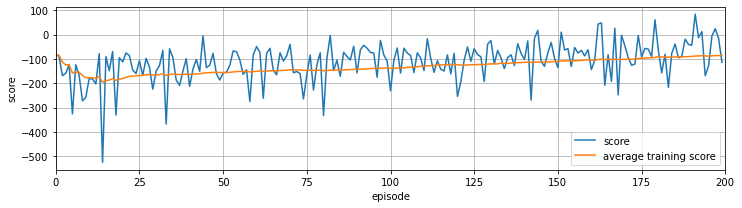

In [23]:
df = pd.read_csv(file_dqn + '.csv')
training_score = df['score']
avg_score = df['avg_score']

plt.figure(figsize=(12,3))

plt.plot(np.arange(len(training_score)), training_score, label='score')
plt.plot(avg_score, label='average training score')
plt.xlabel('episode'); plt.ylabel('score')
plt.xlim((0, len(training_score)))
plt.legend(loc=4); plt.grid()


# save the figure
plt.savefig('DQN_training_rewards.png', bbox_inches='tight')



### DDQN

In [ ]:
df = pd.read_csv(file_ddqn + '.csv')
training_score = df['score']
avg_score = df['avg_score']

plt.figure(figsize=(12,3))

plt.plot(np.arange(len(training_score)), training_score, label='score')
plt.plot(avg_score, label='average training score')
plt.xlabel('episode'); plt.ylabel('score')
plt.xlim((0, len(training_score)))
plt.legend(loc=4); plt.grid()


# save the figure
plt.savefig('DDQN_training_rewards.png', bbox_inches='tight')